In [1]:
%matplotlib inline

# Model Building Part 1

Code for building the models  
_Author: Jimmy Charité_  
_Email: jimmy.charite@gmail.com_  

In model building part one, I experiment with using macro-level text summary statistics as features.

In [2]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import Image
from IPython.core.display import HTML

In [3]:
retval=os.chdir("..")

In [4]:
clean_data=pd.read_pickle('./clean_data/clean_data.pkl')

In [5]:
clean_data.head()

,helpful,num_sents,num_words,readability,neg_senti,pos_senti,neu_senti,comp_senti,text_lemma,vec0,...,vec290,vec291,vec292,vec293,vec294,vec295,vec296,vec297,vec298,vec299
0,0.0,0.693147,3.610918,6.742881,0.079,0.068,0.853,-0.1027,product arrive label peanut actually small siz...,-0.019901,...,-0.178709,0.120293,0.048853,-0.028560,0.024294,-0.051074,-0.082868,-0.058978,0.058156,0.020952
1,0.0,1.386294,3.555348,6.734948,0.000,0.448,0.552,0.9468,great taffy great price wide assortment yummy ...,-0.076091,...,-0.125921,0.026862,-0.011833,-0.023788,0.028657,-0.001059,-0.003236,-0.048324,-0.050874,0.113610
2,0.0,1.609438,4.521789,6.743588,0.029,0.163,0.809,0.8830,get wild hair taffy order pound bag taffy enjo...,-0.048797,...,-0.154745,0.004021,0.004185,0.006071,-0.032341,0.030001,0.004792,-0.122627,-0.015319,0.046176
3,0.0,1.609438,4.143135,6.742527,0.034,0.273,0.693,0.9346,saltwater taffy great flavor soft chewy candy ...,-0.009421,...,-0.185385,0.038134,0.014824,-0.012089,0.007642,-0.013590,0.038388,-0.117533,0.042929,0.137415
4,0.0,1.609438,3.526361,6.737915,0.000,0.480,0.520,0.9487,taffy good soft chewy flavor amazing definitel...,-0.073490,...,-0.155703,0.041312,-0.121036,-0.063175,0.075995,-0.005276,0.051416,-0.136569,0.021066,0.123007


In [6]:
kept_cols=['helpful', 'num_sents', 'num_words', 'readability', 'neg_senti',
       'pos_senti', 'neu_senti', 'comp_senti']

## Training and Testing Split

In [7]:
my_rand_state=0
test_size=0.25

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
X = (clean_data[kept_cols].iloc[:,1:]).as_matrix()
y = (clean_data[kept_cols].iloc[:,0]).tolist()

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                              random_state=my_rand_state)

## Feature Selection

In [11]:
from sklearn.feature_selection import VarianceThreshold

In [12]:
vt = VarianceThreshold()
threshold=[p*(1-p) for p in [0, 0.05, 0.1, 0.15]]

## Scaling

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
std_scale=StandardScaler()

## Classification Models

In [15]:
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

Although tuning is not necessary for Naive Bayes, I pass the default parameters of those models to GridSearchCV anyway so that I can do a direct pair-wise comparison with the other models across the different steps of cross-validation.  

In the interest of time, I didn't use the SVM classifier.

In [16]:
nb_clf=GaussianNB()
priors=[None]

In [17]:
qda_clf=QuadraticDiscriminantAnalysis()
reg_param=[0.0, 0.25, 0.5, 0.75]

In [18]:
log_clf=LogisticRegression(penalty='l2')
C=[0.001 , 0.01, 10, 100,1000]

In [19]:
knn_clf=KNeighborsClassifier(n_jobs=4)
n_neighbors=[2,3,4,5,6,7]
weights=['uniform','distance']

In [20]:
rf_clf=RandomForestClassifier()
n_estimators=[100,200]
max_features=[.1,.3,.5]

In [21]:
dtree=DecisionTreeClassifier(max_depth=None, min_samples_split=2)
bagTree_clf=BaggingClassifier(base_estimator=dtree)
max_samples=[.3,.6]

In [22]:
class_weight=['balanced']
class_weight.extend([{1: w} for w in [1, 2, 10]])

## Creating Pipelines

In [23]:
from imblearn import pipeline #needed if mixing imblearn with sklearn classes
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

I plan on using imblearn classes for later iterations so I use it's pipeline in the beginning for convenience

In [24]:
n_jobs=4

In [25]:
n_folds=10
skfold = StratifiedKFold(n_splits=n_folds,random_state=my_rand_state, shuffle=False)

#### Naive Bayes Estimators

In [26]:
nb_clf_b = pipeline.Pipeline(steps=[('vt',vt),('scale',std_scale),('clf',nb_clf)])
nb_clf_est_b = GridSearchCV(estimator=nb_clf_b,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,clf__priors=priors))

#### QDA Estimators

In [27]:
qda_clf_b = pipeline.Pipeline(steps=[('vt',vt),('scale',std_scale),('clf',qda_clf)])
qda_clf_est_b = GridSearchCV(estimator=qda_clf_b,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,clf__reg_param=reg_param))

#### Logistic Estimators

In [28]:
log_clf_b = pipeline.Pipeline(steps=[('vt',vt),('scale',std_scale),('clf',log_clf)])
log_clf_est_b = GridSearchCV(estimator=log_clf_b,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,clf__C=C,
              clf__class_weight=class_weight))

#### KNN Estimators

In [29]:
knn_clf_b = pipeline.Pipeline(steps=[('vt',vt),('scale',std_scale),('clf',knn_clf)])
knn_clf_est_b = GridSearchCV(estimator=knn_clf_b,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,
              clf__n_neighbors=n_neighbors,
              clf__weights=weights))

#### Random Forest Estimators

In [30]:
rf_clf_b = pipeline.Pipeline(steps=[('vt',vt),('scale',std_scale),('clf',rf_clf)])
rf_clf_est_b = GridSearchCV(estimator=rf_clf_b,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(vt__threshold=threshold,
              clf__n_estimators=n_estimators,
              clf__max_features=max_features,
              clf__class_weight=class_weight))

#### Bagged Estimators

In [31]:
bagTree_clf_b = pipeline.Pipeline(steps=[('vt',vt),('scale',std_scale),('clf',bagTree_clf)])
bagTree_clf_est_b = GridSearchCV(estimator=bagTree_clf_b,cv=skfold,
              scoring='roc_auc',n_jobs=n_jobs,
              param_grid=dict(clf__n_estimators=n_estimators,
              clf__max_samples=max_samples,
              clf__max_features=[len(X_train[0,])]))

## Fitting Estimators

In [32]:
from sklearn.externals import joblib

Basic Estimators: no bag of words or PCA

In [33]:
nb_clf_est_b.fit(X_train,y_train)
joblib.dump(nb_clf_est_b, './other_output/nb_clf_est_b.pkl')

['./other_output/nb_clf_est_b.pkl']

In [34]:
qda_clf_est_b.fit(X_train,y_train)
joblib.dump(qda_clf_est_b, './other_output/qda_clf_est_b.pkl')

['./other_output/qda_clf_est_b.pkl']

In [35]:
log_clf_est_b.fit(X_train,y_train)
joblib.dump(log_clf_est_b, './other_output/log_clf_est_b.pkl')

['./other_output/log_clf_est_b.pkl']

In [36]:
knn_clf_est_b.fit(X_train,y_train)
joblib.dump(knn_clf_est_b, './other_output/knn_clf_est_b.pkl')

['./other_output/knn_clf_est_b.pkl']

In [37]:
rf_clf_est_b.fit(X_train,y_train)
joblib.dump(rf_clf_est_b, './other_output/rf_clf_est_b.pkl')

['./other_output/rf_clf_est_b.pkl']

In [38]:
bagTree_clf_est_b.fit(X_train,y_train)
joblib.dump(bagTree_clf_est_b, './other_output/bagTree_clf_est_b.pkl')

['./other_output/bagTree_clf_est_b.pkl']

## Testing Estimators

In [37]:
from sklearn.metrics import roc_curve, auc

In [36]:
nb_clf_est_b=joblib.load('./other_output/nb_clf_est_b.pkl')
qda_clf_est_b=joblib.load('./other_output/qda_clf_est_b.pkl')
log_clf_est_b=joblib.load('./other_output/log_clf_est_b.pkl')
knn_clf_est_b=joblib.load('./other_output/knn_clf_est_b.pkl')
rf_clf_est_b=joblib.load('./other_output/rf_clf_est_b.pkl')
bagTree_clf_est_b=joblib.load('./other_output/bagTree_clf_est_b.pkl')

In [53]:
nb_fpr, nb_tpr, _ = roc_curve(y_test, 
                    nb_clf_est_b.predict_proba(X_test)[:,1])
nb_roc_auc = auc(nb_fpr, nb_tpr)

qda_fpr, qda_tpr, _ = roc_curve(y_test, 
                    qda_clf_est_b.predict_proba(X_test)[:,1])
qda_roc_auc = auc(qda_fpr, qda_tpr)

log_fpr, log_tpr, _ = roc_curve(y_test, 
                    log_clf_est_b.predict_proba(X_test)[:,1])
log_roc_auc = auc(log_fpr, log_tpr)

knn_fpr, knn_tpr, _ = roc_curve(y_test, 
                    knn_clf_est_b.predict_proba(X_test)[:,1])
knn_roc_auc = auc(knn_fpr, knn_tpr)

rf_fpr, rf_tpr, _ = roc_curve(y_test, 
                    rf_clf_est_b.predict_proba(X_test)[:,1])
rf_roc_auc = auc(rf_fpr, rf_tpr)

bagTree_fpr, bagTree_tpr, _ = roc_curve(y_test, 
                    bagTree_clf_est_b.predict_proba(X_test)[:,1])
bagTree_roc_auc = auc(bagTree_fpr, bagTree_tpr)

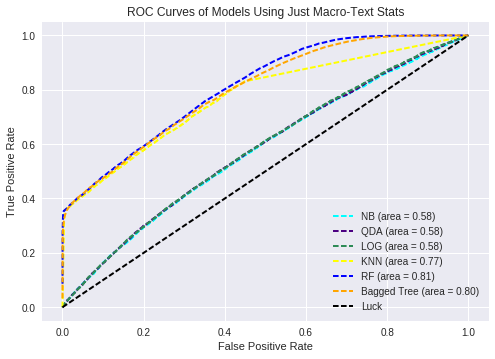

In [54]:
plt.plot(nb_fpr, nb_tpr, color='cyan', linestyle='--',
         label='NB (area = %0.2f)' % nb_roc_auc, lw=2)

plt.plot(qda_fpr, qda_tpr, color='indigo', linestyle='--',
         label='QDA (area = %0.2f)' % qda_roc_auc, lw=2)

plt.plot(log_fpr, log_tpr, color='seagreen', linestyle='--',
         label='LOG (area = %0.2f)' % log_roc_auc, lw=2)

plt.plot(knn_fpr, knn_tpr, color='yellow', linestyle='--',
         label='KNN (area = %0.2f)' % knn_roc_auc, lw=2)

plt.plot(rf_fpr, rf_tpr, color='blue', linestyle='--',
         label='RF (area = %0.2f)' % rf_roc_auc, lw=2)

plt.plot(bagTree_fpr, bagTree_tpr, color='orange', linestyle='--',
         label='Bagged Tree (area = %0.2f)' % bagTree_roc_auc, lw=2)

plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k',
         label='Luck')

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Models Using Just Macro-Text Stats')
plt.legend(loc="lower right")
plt.savefig('./plots/ROC_Basic.png', bbox_inches='tight')
plt.show()

Closer look at variability in performance

In [43]:
from scipy.stats import sem

In [44]:
len(y_test) #the sample is large enough that we can get away with 5% draws

49665

In [45]:
y_test=np.array(y_test)

In [46]:
X_test=np.array(X_test)

In [47]:
#initialize 
n_bootstraps = 2000
rng_seed = 1
sample_percent=0.05
min_index=0
max_index=len(y_test)-1

In [48]:
draw_size=int(len(y_test)*sample_percent)
bootstrapped_scores = []
rng = np.random.RandomState(rng_seed)

In [49]:
for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on 
    indices = rng.random_integers(min_index, max_index, draw_size)
    
    #calculate ROC from 
    rf_fpr, rf_tpr, _ = roc_curve(y_test[indices], 
                    rf_clf_est_b.predict_proba(X_test[indices,:])[:,1])
    rf_roc_auc = auc(rf_fpr, rf_tpr)
    
    #save
    bootstrapped_scores.append(rf_roc_auc)

/home/jimmy/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: This function is deprecated. Please call randint(0, 49664 + 1) instead
  app.launch_new_instance()


In [50]:
import pickle

In [51]:
with open('./other_output/rf_bootstrapped_scores.pkl', 'wb') as f:
    pickle.dump(bootstrapped_scores, f)

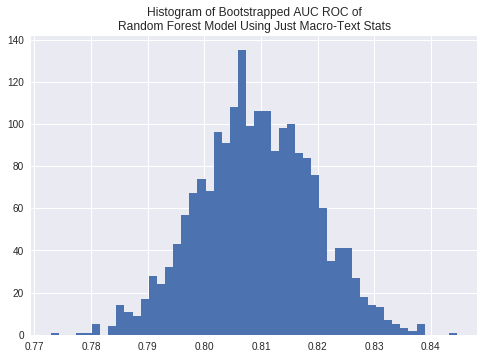

In [58]:
plt.hist(bootstrapped_scores, bins=50)
plt.title('Histogram of Bootstrapped AUC ROC of\nRandom Forest Model Using Just Macro-Text Stats')
plt.savefig('./plots/ROC_Histogram_Basic.png', bbox_inches='tight')
plt.show()

In [59]:
pd.DataFrame({'auc':bootstrapped_scores}).auc.describe()

count    2000.000000
mean        0.809162
std         0.010206
min         0.772989
25%         0.802315
50%         0.809038
75%         0.816355
max         0.844636
Name: auc, dtype: float64

##### What were the most important variables?

In [39]:
rf_clf_b.set_params(**rf_clf_est_b.best_params_).fit(X_train,y_train)

Pipeline(steps=[('vt', VarianceThreshold(threshold=0)), ('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', RandomForestClassifier(bootstrap=True, class_weight={1: 1}, criterion='gini',
            max_depth=None, max_features=0.1, max_leaf_nodes=None,
            min_impurity_split=...mators=200, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))])

In [53]:
feature_importance=pd.DataFrame({'feature':clean_data[kept_cols].columns[1:],
                                 'importance':rf_clf_b.named_steps['clf'].feature_importances_})

In [55]:
feature_importance.sort_values(by='importance',inplace=True,ascending=False)
feature_importance

,feature,importance
6,comp_senti,0.188652
2,readability,0.171777
5,neu_senti,0.161051
1,num_words,0.160440
4,pos_senti,0.157159
3,neg_senti,0.106183
0,num_sents,0.054737


It is not surprising that the overall sentiment polarity score (comp_senti) and the readability score are the most important features. These are the most "information dense" features in that they summarize complex characteristics about the food review. 

##### Final thoughts on why the tree models and nearest neighbors are the best models

Given that the best models were the tree-based ones and the nearest neighbors, it must be true that the decision boundary is highly non-linear.

While it is not realistic to create scatter plots of all 27 combinations of features, I create a two scatter plots to get a sense of the separability of the two classes.

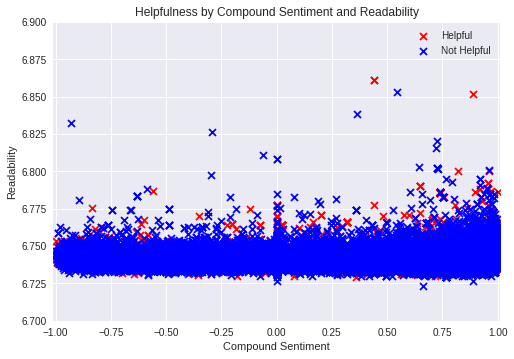

In [71]:
help_true=plt.scatter(clean_data[clean_data.helpful==1]['comp_senti'],
                      clean_data[clean_data.helpful==1]['readability'],
                      color='red',marker='x')
help_false=plt.scatter(clean_data[clean_data.helpful==0]['comp_senti'],
                      clean_data[clean_data.helpful==0]['readability'],
                      color='blue',marker='x')
plt.legend((help_true,help_false),('Helpful','Not Helpful'))
plt.xlabel('Compound Sentiment')
plt.ylabel('Readability')
plt.xlim(-1.01, 1.01)
plt.ylim(6.7, 6.9)
plt.title('Helpfulness by Compound Sentiment and Readability')
plt.show()

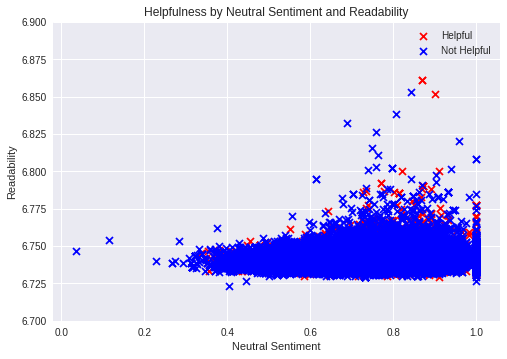

In [72]:
help_true=plt.scatter(clean_data[clean_data.helpful==1]['neu_senti'],
                      clean_data[clean_data.helpful==1]['readability'],
                      color='red',marker='x')
help_false=plt.scatter(clean_data[clean_data.helpful==0]['neu_senti'],
                      clean_data[clean_data.helpful==0]['readability'],
                      color='blue',marker='x')
plt.legend((help_true,help_false),('Helpful','Not Helpful'))
plt.xlabel('Neutral Sentiment')
plt.ylabel('Readability')
plt.ylim(6.7, 6.9)
plt.title('Helpfulness by Neutral Sentiment and Readability')
plt.show()

The two plots above help explain why the logistic, QDA, and naive bayes models performed so comparatively poorly. The classes seem highly compact along some of the most important features. 